#Image retrieval with prompts with MetaCLIP

## Installing dependencies

In [ ]:
! pip install transformers torch faiss-gpu datasets

## Loading the model

In [ ]:
import torch
from PIL import Image
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification, AutoTokenizer
from tqdm import tqdm
#Only needed in Google colab
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import faiss
import numpy as np

#Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model, processor and tokenizer
processor = AutoProcessor.from_pretrained("facebook/metaclip-b16-fullcc2.5b")
model = AutoModelForZeroShotImageClassification.from_pretrained("facebook/metaclip-b16-fullcc2.5b",  torch_dtype=torch.float16).to(device)
model = torch.compile(model)
tokenizer = AutoTokenizer.from_pretrained("facebook/metaclip-b16-fullcc2.5b")

## Loading the dataset

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

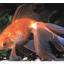

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [3]:
#Load tiny-imagenet dataset
dataset = load_dataset("zh-plus/tiny-imagenet")

#Display an image
display(dataset['valid'][0]['image'])

#Keep only validation set
valid_dataset = dataset["valid"]
print(valid_dataset)

## Extracting features of image

In [4]:
#Add a vector to FAISS index
def add_vector_to_index(embedding, index):
    #convert embedding to numpy
    vector = embedding.detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

#Extract features of a given image
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features

#FAISS index
index = faiss.IndexFlatL2(512)

#Process the dataset to extract all features and store in index
for image in tqdm(valid_dataset):
    clip_features = extract_features_clip(image['image'])
    add_vector_to_index(clip_features,index)

#Write index locally. Not needed after but can be useful for future retrieval
faiss.write_index(index,"metaclip.index")

100%|██████████| 10000/10000 [03:11<00:00, 52.09it/s]


## Image retrieval with prompts

distances [[1.2859557 1.3031354 1.308345  1.3097203 1.3123536]]
indices [[1291 1246 1176 9374 1249]]
Similarity score: 43.74538028970193


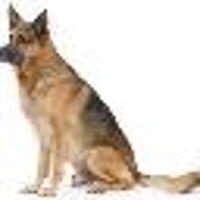

Similarity score: 43.41907132985854


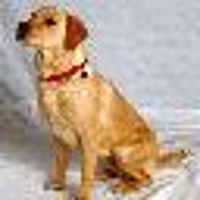

Similarity score: 43.32108143437334


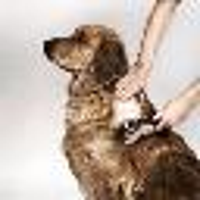

Similarity score: 43.29528599707525


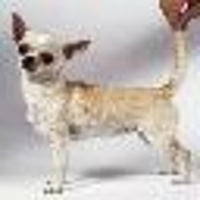

Similarity score: 43.245980858905625


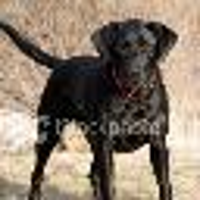

In [8]:
#Let's search images of dogs
prompt="a photo of a dog"

#Tokenize the prompt and extract features
text_token = tokenizer([prompt], return_tensors="pt").to(device)
text_features = model.get_text_features(**text_token)

#Preprocess the vector before search in FAISS index
text_np = text_features.detach().cpu().numpy()
text_np = np.float32(text_np)
faiss.normalize_L2(text_np)

#Search the top 5 images
distances, indices = index.search(text_np, 5)
print('distances',distances)
print('indices' ,indices)

#For each top-5 results, compute similarity score between 0 and 1, print indice, similarity score and display image
for i,v in enumerate(indices[0]):
    sim = (1/(1+distances[0][i])*100)
    print(f"Similarity score: {sim}")
    img_resized = valid_dataset[int(v)]['image'].resize((200, 200))
    display(img_resized)